In [4]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import scipy as scipy
from scipy import optimize
from scipy.special import binom
from scipy.optimize import brentq
import scipy as sp, numpy as np
from sklearn.preprocessing import scale, StandardScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import LeaveOneGroupOut, LeaveOneOut
import matplotlib.pyplot as plt

data = np.loadtxt('parkinsons_updrs_2.csv', delimiter=",")
data_columns = ['subject','age','sex','test_time','motor_UPDRS','total_UPDRS','Jitter(%)','Jitter(Abs)','Jitter:RAP','Jitter:PPQ5','Jitter:DDP','Shimmer','Shimmer(dB)','Shimmer:APQ3','Shimmer:APQ5','Shimmer:APQ11','Shimmer:DDA','NHR','HNR','RPDE','DFA','PPE']

There are 5875 measurements and 22 types of data points. Each of the types of data refer to either a doctor's observation or an observation collected by an experimental in home voice monitoring device. A description of each data time is as follows.

subject# - Integer that uniquely identifies each subject
age - Subject age
sex - Subject gender '0' - male, '1' - female
test_time - Time since recruitment into the trial. The integer part is the 
number of days since recruitment.
motor_UPDRS - Clinician's motor UPDRS score, linearly interpolated
total_UPDRS - Clinician's total UPDRS score, linearly interpolated
Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,Jitter:DDP - Several measures of 
variation in fundamental frequency
Shimmer,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA - 
Several measures of variation in amplitude
NHR,HNR - Two measures of ratio of noise to tonal components in the voice
RPDE - A nonlinear dynamical complexity measure
DFA - Signal fractal scaling exponent
PPE - A nonlinear measure of fundamental frequency variation 

PPE and HNR have been found by other papers to be significant factors in predicting whether patients have or do not have parkinsons. Since everyone we have data on here does have Parkinsons, we will instead try to use the data to predict UPDRS scores, which is a composite measure of the severity of the progresiion of the disease. We will first use PLSR on these two variables with cross validation and the amount of components found to explain 90% variance, as well as explore the use of all the variables in tandem. We will use UPDRS as the output Y vector

In [17]:
# First I want to check the correlation coefficient of each of the variables with the UPDRS scores. Some are in DB and
#some are non-linear, so not all results will be useful
Y = data[:,5]

for i in range (6,21):
    corrco = np.corrcoef(Y, data[:,i])
    corrco = corrco[1,0]
    print ('Our generated Correlation Coefficient is', corrco, 'for relationship between total UPDRS and ',data_columns[i])
    

corrco = np.corrcoef(Y, data[:,4])
corrco = corrco[1,0]
print ('Our generated Correlation Coefficient is', corrco, 'for relationship between total UPDRS and ',data_columns[4])

Our generated Correlation Coefficient is 0.07424666887775348 for relationship between total UPDRS and  Jitter(%)
Our generated Correlation Coefficient is 0.06692562254183249 for relationship between total UPDRS and  Jitter(Abs)
Our generated Correlation Coefficient is 0.06401541705530797 for relationship between total UPDRS and  Jitter:RAP
Our generated Correlation Coefficient is 0.0633517753115959 for relationship between total UPDRS and  Jitter:PPQ5
Our generated Correlation Coefficient is 0.06402745721052847 for relationship between total UPDRS and  Jitter:DDP
Our generated Correlation Coefficient is 0.09214091373482056 for relationship between total UPDRS and  Shimmer
Our generated Correlation Coefficient is 0.09878973052896532 for relationship between total UPDRS and  Shimmer(dB)
Our generated Correlation Coefficient is 0.07936271837795882 for relationship between total UPDRS and  Shimmer:APQ3
Our generated Correlation Coefficient is 0.08346725201072153 for relationship between to

Text(0, 0.5, 'R2Y - Percent coVar Explained')

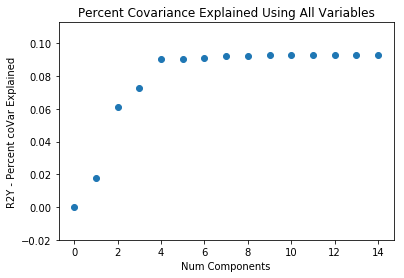

In [6]:
#with all variables except gender and test time
R2yhold = np.zeros(15)
componhold = np.zeros(15)
Y = data[:,5]

X = data[:,6:21]

Xreduced = np.zeros([len(data),2])
Xreduced[:,0] = data[:,21] #ppe
Xreduced[:,1] = data[:,18] #hnr
checker = 0


for i in range (1,len(R2yhold)):
    PLSRfun = PLSRegression (n_components=i)
    componhold[i-1] = i
    mod = PLSRfun.fit_transform(scale(X),scale(Y))
    R2yhold [i-1] = PLSRfun.score(scale(X),scale(Y))
    if R2yhold [i-1] > .9 and checker == 0:
        print('90% covariance is explained when using ',i,'components')
        checker = checker+1
        
plt.figure()
plt.scatter(componhold,R2yhold)
plt.title('Percent Covariance Explained Using All Variables')
plt.xlabel('Num Components')
plt.ylabel('R2Y - Percent coVar Explained')

(5875, 4)


Text(0, 0.5, 'R2Y - Percent coVar Explained')

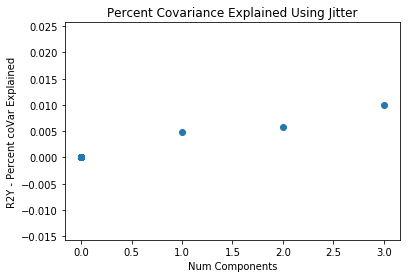

In [7]:
#with only Jitter
R2yhold = np.zeros(15)
componhold = np.zeros(15)
Y = data[:,5]

X = data[:,6:10]

print(X.shape)
Xreduced = np.zeros([len(data),2])
Xreduced[:,0] = data[:,21] #ppe
Xreduced[:,1] = data[:,18] #hnr
checker = 0


for i in range (1,X.shape[1]):
    PLSRfun = PLSRegression (n_components=i)
    componhold[i-1] = i
    mod = PLSRfun.fit_transform(scale(X),scale(Y))
    R2yhold [i-1] = PLSRfun.score(scale(X),scale(Y))
    if R2yhold [i-1] > .9 and checker == 0:
        print('90% covariance is explained when using ',i,'components')
        checker = checker+1
        
plt.figure()
plt.scatter(componhold,R2yhold)
plt.title('Percent Covariance Explained Using Jitter')
plt.xlabel('Num Components')
plt.ylabel('R2Y - Percent coVar Explained')

(5875, 5)


Text(0, 0.5, 'R2Y - Percent coVar Explained')

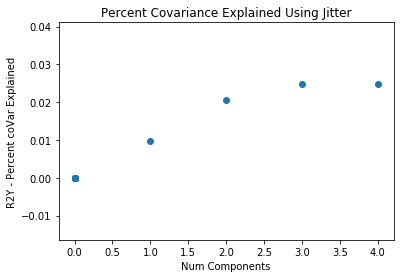

In [8]:
#with only Shimmer
R2yhold = np.zeros(15)
componhold = np.zeros(15)
Y = data[:,5]

X = data[:,11:16]

print(X.shape)
Xreduced = np.zeros([len(data),2])
Xreduced[:,0] = data[:,21] #ppe
Xreduced[:,1] = data[:,18] #hnr
checker = 0


for i in range (1,X.shape[1]):
    PLSRfun = PLSRegression (n_components=i)
    componhold[i-1] = i
    mod = PLSRfun.fit_transform(scale(X),scale(Y))
    R2yhold [i-1] = PLSRfun.score(scale(X),scale(Y))
    if R2yhold [i-1] > .9 and checker == 0:
        print('90% covariance is explained when using ',i,'components')
        checker = checker+1
        
plt.figure()
plt.scatter(componhold,R2yhold)
plt.title('Percent Covariance Explained Using Jitter')
plt.xlabel('Num Components')
plt.ylabel('R2Y - Percent coVar Explained')

(5875, 4)


Text(0, 0.5, 'R2Y - Percent coVar Explained')

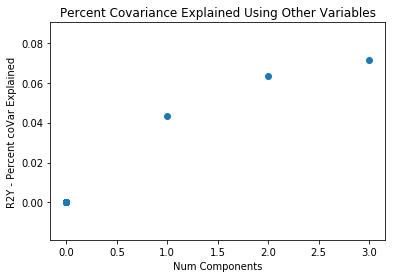

In [9]:
#with other measurements
R2yhold = np.zeros(15)
componhold = np.zeros(15)
Y = data[:,5]

X = data[:,17:21]

print(X.shape)
Xreduced = np.zeros([len(data),2])
Xreduced[:,0] = data[:,21] #ppe
Xreduced[:,1] = data[:,18] #hnr
checker = 0


for i in range (1,X.shape[1]):
    PLSRfun = PLSRegression (n_components=i)
    componhold[i-1] = i
    mod = PLSRfun.fit_transform(scale(X),scale(Y))
    R2yhold [i-1] = PLSRfun.score(scale(X),scale(Y))
    if R2yhold [i-1] > .9 and checker == 0:
        print('90% covariance is explained when using ',i,'components')
        checker = checker+1
        
plt.figure()
plt.scatter(componhold,R2yhold)
plt.title('Percent Covariance Explained Using Other Variables')
plt.xlabel('Num Components')
plt.ylabel('R2Y - Percent coVar Explained')

We will use 4 components with all our varialbes as it gives us the best mix of computational efficiency and R2Y. This covariance explained is less than optimal - we will continue to try to use PLSR and see if we can get a good relationship between our predicted results and measured results using leave one out cross validation

Our generated Correlation Coefficient is 0.29600407321113625
This beats our previous best correlation coefficient of 0.16 for RPDE


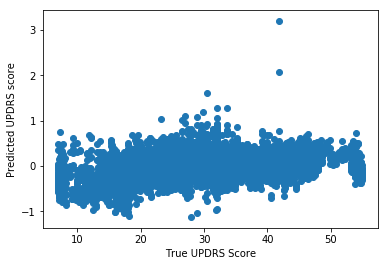

In [42]:
#leave one out
from sklearn.model_selection import LeaveOneOut
Y = data[:,5]
X = data[:,6:21]
leave = LeaveOneOut()
leaveoneoutindices = np.arange(len(X))
predictholder = np.zeros(len(X))
plt.figure()
plt.xlabel('True UPDRS Score')
plt.ylabel('Predicted UPDRS score')
scaledX=scale(X)
scaledY = scale(Y)


for train_index, test_index in leave.split(leaveoneoutindices):
    trainX = scaledX[train_index]
    trainY = scaledY[train_index]
    PLS = PLSRegression(n_components = 4, max_iter = 1000)
    trainedmod = PLSRfun.fit_transform(trainX,trainY)
    predictholder[test_index] = PLSRfun.predict(scaledX[test_index])

plt.scatter(Y,predictholder)
#need to calculate r2y
r2y = 1-(np.sum((scale(predictholder)-scaledY)**2))/(np.sum((scaledY)**2))

corrco = np.corrcoef(Y, predictholder)
corrco = corrco[1,0]
print ('Our generated Correlation Coefficient is', corrco)
print('This beats our previous best correlation coefficient of 0.16 for RPDE')

Now let's try with cross validation and groups of 25 observations.

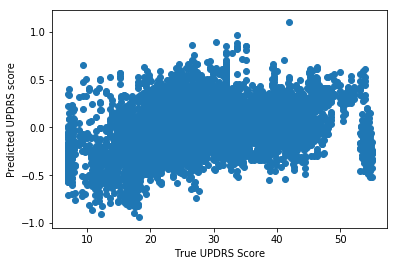

In [18]:
#k = 25 - fold cross validation
from sklearn.model_selection import KFold
Y = data[:,5]
X = data[:,6:21]
kf = KFold(n_splits=int(len(X)/25), shuffle=True)

leaveoneoutindices = np.arange(len(X))
predictholder = np.zeros(len(X))
plt.figure()
plt.xlabel('True UPDRS Score')
plt.ylabel('Predicted UPDRS score')
scaledX=scale(X)
scaledY = scale(Y)
checker = 0


for train_index, test_index in kf.split(leaveoneoutindices):
    trainX = scaledX[train_index]
    trainY = scaledY[train_index]
    PLS = PLSRegression(n_components = 4, max_iter = 1000)
    trainedmod = PLSRfun.fit_transform(trainX,trainY)
    predicts = PLSRfun.predict(scaledX[test_index])
    for i in range (0,len(test_index)):
        predictholder[test_index[i]] = predicts[i]
                               
plt.scatter(Y,predictholder)
#need to calculate r2y


In [15]:
corrco = np.corrcoef(Y, predictholder)
corrco = corrco[1,0]
print ('Our generated Correlation Coefficient is', corrco)
print('This beats our previous best correlation coefficient of 0.16 for RPDE')

Our generated Correlation Coefficient is 0.26087029609913037
This beats our previous best correlation coefficient of 0.16 for RPDE


Lets see if we can get better prediciton accuracy while only using our 4 best correlated variables with total UPDRS

Our generated Correlation Coefficient is 0.2133879182993585
This beats our previous best correlation coefficient of 0.16 for RPDE


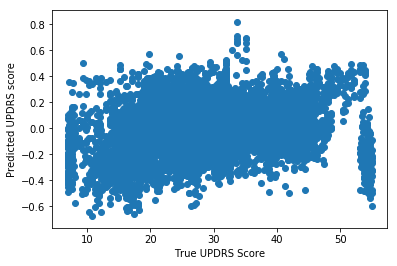

In [13]:
#k = 25 - fold cross validati0n
from sklearn.model_selection import KFold
Y = data[:,5]
X = np.zeros([len(data),4])
X[:,0] = data[:,17]
X[:,1:3] = data[:,19:21]
kf = KFold(n_splits=int(len(X)/25), shuffle=True)

leaveoneoutindices = np.arange(len(X))
predictholder = np.zeros(len(X))
plt.figure()
plt.xlabel('True UPDRS Score')
plt.ylabel('Predicted UPDRS score')
scaledX=scale(X)
scaledY = scale(Y)
checker = 0


for train_index, test_index in kf.split(leaveoneoutindices):
    trainX = scaledX[train_index]
    trainY = scaledY[train_index]
    PLS = PLSRegression(n_components = 4, max_iter = 1000)
    trainedmod = PLSRfun.fit_transform(trainX,trainY)
    predicts = PLSRfun.predict(scaledX[test_index])
    for i in range (0,len(test_index)):
        predictholder[test_index[i]] = predicts[i]
                               
plt.scatter(Y,predictholder)
#need to calculate r2y

corrco = np.corrcoef(Y, predictholder)
corrco = corrco[1,0]
print ('Our generated Correlation Coefficient is', corrco)
print('This beats our previous best correlation coefficient of 0.16 for RPDE')


Using more variables leads to better predictions, and substituting motor and total UPDRS scores seems to make a negligible difference. There do seem to be some points that are lessening our prediction accuracy towards the larger UPDRS scores though

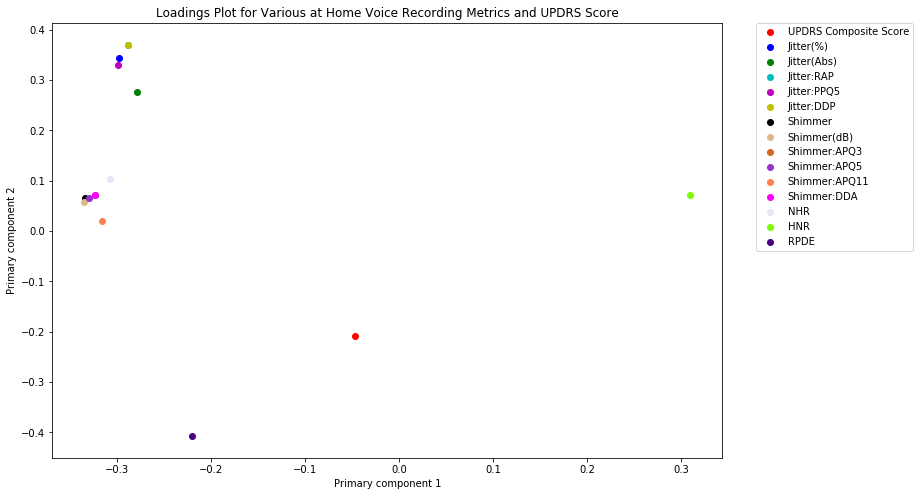

In [41]:
colorsmat = ['b','g','c','m','y','k','burlywood','chocolate','darkorchid','coral','magenta','lavender','lawngreen','indigo','darksalmon']
Y = data[:,5]
X = data[:,6:21]
PLSRfun = PLSRegression (n_components=4)
mod1,mod2 = PLSRfun.fit_transform(scale(X),scale(Y))
xloadscores,yloadscores = PLSRfun.x_loadings_, PLSRfun.y_loadings_

plt.figure(figsize=(12, 8))
plt.title('Loadings Plot for Various at Home Voice Recording Metrics and UPDRS Score')
plt.xlabel('Primary component 1')
plt.ylabel('Primary component 2')
plt.scatter(yloadscores[:,0],yloadscores[:,1],c = 'r', label = 'UPDRS Composite Score')

for i in range (0,14):
    plt.scatter(xloadscores[i,0],xloadscores[i,1],c = colorsmat[i], label = data_columns[i+6])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()


Now lets examine the accuracy of voice metrics for each patient, and see if there are dramatic differences in whether voice is a useful predictor of UPDRS scores for each one using LOOCV.

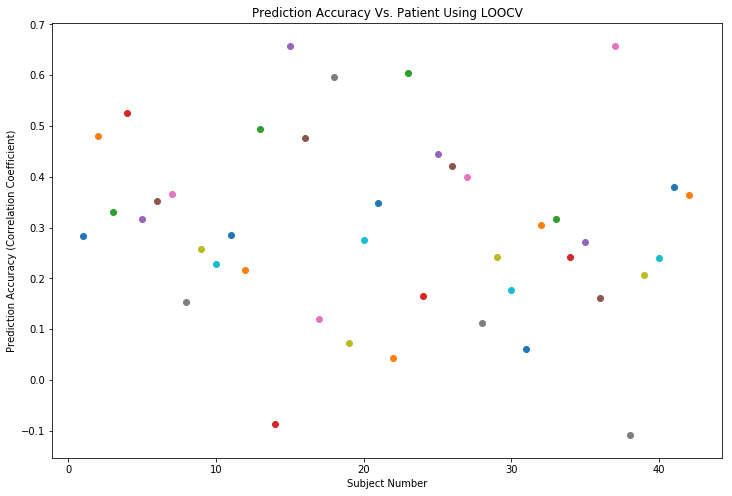

In [68]:
plt.figure(figsize = (12,8))
plt.title('Prediction Accuracy Vs. Patient Using LOOCV')
plt.xlabel('Subject Number')
plt.ylabel('Prediction Accuracy (Correlation Coefficient)')
for i in range(0, int(np.amax(data[:,0]))):    
    subjects = data[:,0]
    Y = data[subjects == (i+1),5]
    X = data[subjects == (i+1),6:21]
    leave = LeaveOneOut()
    leaveoneoutindices = np.arange(len(X))
    predictholder = np.zeros(len(X))
    scaledX=scale(X)
    scaledY = scale(Y)


    for train_index, test_index in leave.split(leaveoneoutindices):
        trainX = scaledX[train_index]
        trainY = scaledY[train_index]
        PLS = PLSRegression(n_components = 4, max_iter = 1000)
        trainedmod = PLSRfun.fit_transform(trainX,trainY)
        predictholder[test_index] = PLSRfun.predict(scaledX[test_index])

    
    corrco = np.corrcoef(Y, predictholder)
    corrco = corrco[1,0]
    plt.scatter(i+1,corrco)
    #print ('Our generated Correlation Coefficient is', corrco, ' for patient number', i+1)

It seems that the two most useful metrics for predicting UPDRS scores are RPDE and HNR measurements. This is corroborated by the fact that these two metrics have the highest correllation coefficient with UPDRS scores. RPDE and HNR represent scores measuring the nonlinear dynamical complexity of recordings, and the ratio of noise to tonal components in the voice respectively. Here we can infer that observations with high RPDE likely have higher UPDRS scores, and that the opposite is likely true of patients with high HNR scores. It is interesting that even though NHR and HNR are described relatively similarly as metrics of voice recordings, they have completely different loadings scores. This gives us somewhat contradicting evidence, as it suggests that patients with more severe Parkinson's progression have more dynamical complexity in their voice, but also a lower noise to tone score. One conclusion may be that patients with more severe disease progression speak in in sporadic tones, which would increase complexity of voice recordings and decrease noise to tone ratio.

While most of the metrics recorded by the in home telemonitoring device have relatively weak correlations with repordted UPDRS scores, we have shown that the composite use of all recording metrics in conjunction with PLSR methods is useful in predicting UPDRS scores, and allows us to produce a model that produces better correlation coefficients with results than any other voice metric. However, as we were only able to produce a model with a somewhat low correlation coefficient of 0.295 with LOOCV and 0.265 with k-fold between true and predicted UPDRS scores, it seems that this at home monitor may only be useful over the long term, and only in stages where physicians might expect the disease to progress rapidly. Given the lengthy time scale of the progression of Parkinsons (20 years), the best use of the technology as is may be to help physicians know when to reach out to patients to schedule check ups instead of putting the onus on the patient. It is also notable that for some patients the PLSR model produces very useful information, with predictions exceeding 70 percent correlation with UPDRS scores. If one could isolate the reason for these people's predictability, the telemonitoring device could only be applied when it would be most useful. Perhaps the at home voice measurements use more standardized voice tests, asking patients to say certain sentences with pre-described intonations, and therefore provide more standardized metrics for better prediction accuracy.

In [64]:
from random import randint
colors = []

for i in range(0,42):
    colors.append('%06X' % randint(0, 0xFFFFFF))

PLSRfun = PLSRegression (n_components=4)
mod1,mod2 = PLSRfun.fit_transform(scale(X),scale(Ytrue))
Y = data[:,5]
X = data[:,6:21]

plt.figure()
colorindex = 0
subjects1 = np.linspace(1,42,42)

parallel = np.zeros(len(colors))
PC1val = np.zeros(len(colors))
PC2val = np.zeros(len(colors))

for i in range (0,len(colors)):
    PC1val[i],PC2val[i] = mod1[i,0],mod1[i,1]
    if drugs[i,colorindex] == 0:
        colorindex = colorindex+1
    parallel[i] = colorindex

for i in range(0,len(drugList)-1):
    plt.scatter(PC1val[parallel == i],PC2val[parallel == i],c = colorsmat[i],label = drugList[i])

plt.legend(loc = 1)
plt.ylim = (-10,10)       
plt.xlim = (-10,10)
plt.xlabel('Primary component 1')
plt.ylabel('Primary component 2')


[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36.
 37. 38. 39. 40. 41. 42.]
